In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, recall_score,
confusion_matrix, roc_curve, auc, precision_score)
from xgboost import XGBClassifier
import pickle

In [10]:
data = pd.read_csv("cancer.csv")
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [11]:
data.drop(["Unnamed: 32"], axis="columns", inplace=True)
data.drop(["id"], axis="columns", inplace=True)

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data["Diagnosis"] = label_encoder.fit_transform(data["diagnosis"])
data.drop(["diagnosis"], axis="columns", inplace=True)
data.head(1)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,1


In [16]:
y = data["Diagnosis"]
X = data.drop(["Diagnosis"], axis="columns")
print("Dataset shape:", X.shape)
print("Feature names (first 10):", list(X.columns)[:10])

Dataset shape: (569, 30)
Feature names (first 10): ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']


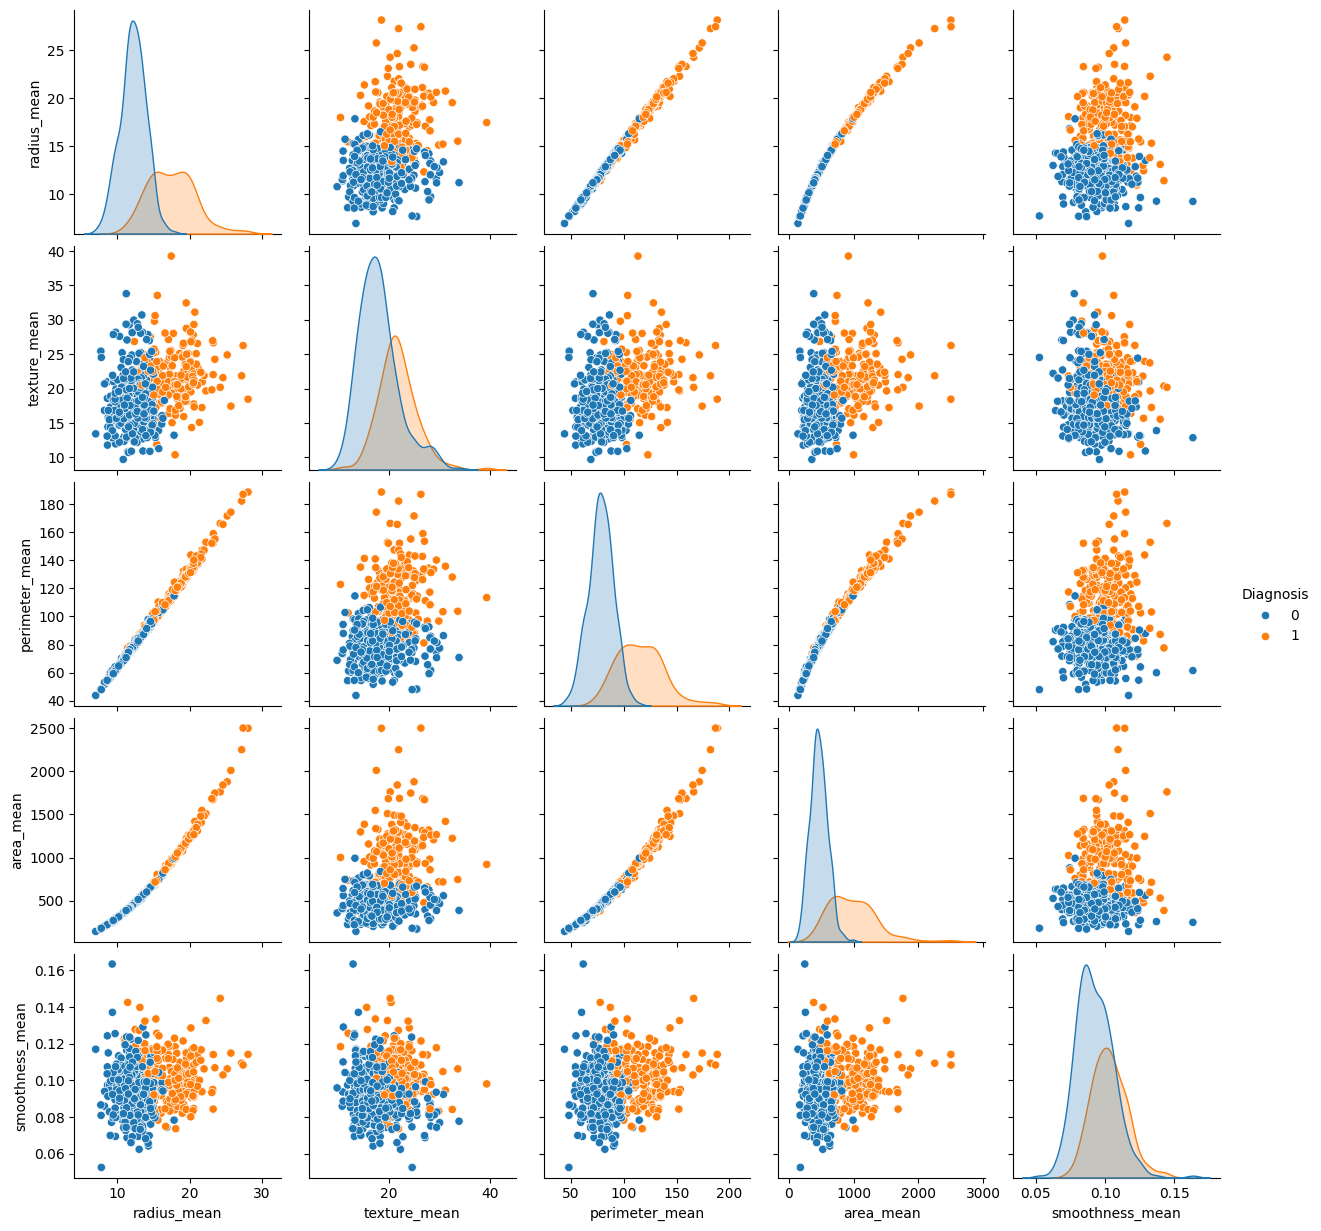

In [15]:

sns.pairplot(data, hue='Diagnosis', vars=['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

xgb = XGBClassifier(
n_estimators=500,
max_depth=4,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
random_state=42,
use_label_encoder=False,
eval_metric='logloss'
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]

c:\Users\atlas\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:50:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [42]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)


print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Recall / Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")

print("Confusion Matrix (\n[[TN, FP],\n [FN, TP]]):\n", cm)

Accuracy: 0.9825
ROC-AUC: 0.9997
Recall / Sensitivity: 1.0000
Specificity: 0.9701
Confusion Matrix (
[[TN, FP],
 [FN, TP]]):
 [[65  2]
 [ 0 47]]


In [23]:
with open('xgb_breast_cancer_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)
print('Saved model to xgb_breast_cancer_model.pkl')

Saved model to xgb_breast_cancer_model.pkl


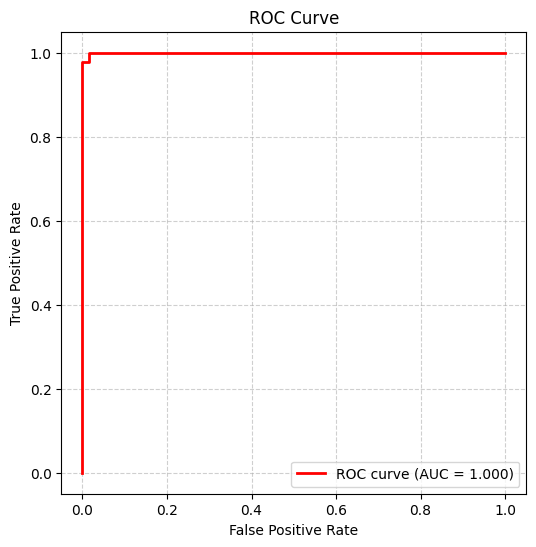

In [33]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('roc_curve.png', dpi=150)
plt.show()


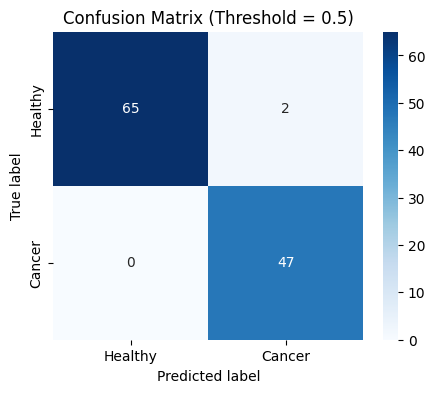

In [34]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Healthy','Cancer'],
            yticklabels=['Healthy','Cancer'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Threshold = 0.5)')
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()


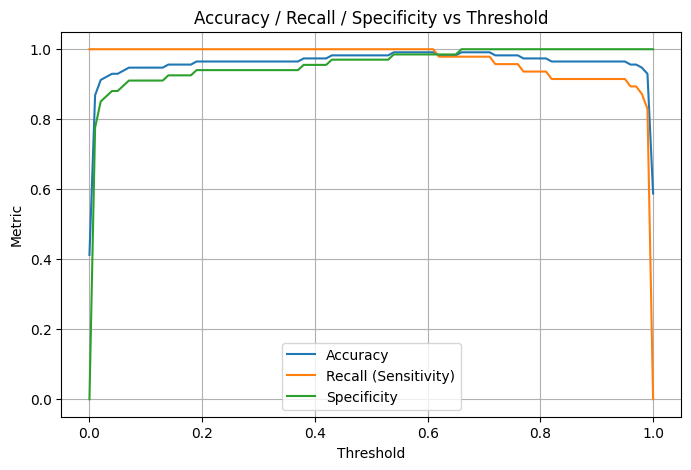

In [39]:
thresholds = np.linspace(0,1,101)
accuracies = []
recalls = []
specificities = []
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    cm_t = confusion_matrix(y_test, y_pred_t)
    if cm_t.size == 4:
        tn, fp, fn, tp = cm_t.ravel()
    else:

        tn = fp = fn = tp = 0
        if np.all(y_test==0):
            tn = cm_t[0,0]
        elif np.all(y_test==1):
            tp = cm_t[0,0]
    accuracies.append(accuracy_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t, zero_division=0))
    specificities.append(tn/(tn+fp) if (tn+fp)>0 else 0)


plt.figure(figsize=(8,5))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, recalls, label='Recall (Sensitivity)')
plt.plot(thresholds, specificities, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Accuracy / Recall / Specificity vs Threshold')
plt.legend()
plt.grid(True)
plt.savefig('metrics_vs_threshold.png', dpi=150)
plt.show()

In [41]:
external_patients = np.array([
[18.0,14.0,115.0,750.0,0.11,0.18,0.06,0.04,0.19,0.07,0.21,0.28,1.05,11.0,0.0055,0.045,0.055,0.025,0.035,0.0065,21.0,16.0,155.0,1650.0,0.16,0.75,0.85,0.27,0.48,0.13],
[20.5,19.0,130.0,900.0,0.13,0.22,0.09,0.06,0.23,0.08,0.27,0.37,1.25,13.0,0.0065,0.055,0.065,0.035,0.045,0.0075,26.0,20.0,185.0,2050.0,0.19,0.85,0.95,0.32,0.52,0.16],
[16.5,15.0,105.0,680.0,0.09,0.12,0.03,0.02,0.16,0.05,0.18,0.25,0.95,9.5,0.0045,0.035,0.045,0.02,0.025,0.0055,18.5,14.5,140.0,1500.0,0.14,0.65,0.75,0.22,0.42,0.11],
[25.5,28.0,175.0,2100.0,0.16,0.38,0.26,0.13,0.36,0.11,0.42,0.65,2.55,26.0,0.0105,0.085,0.105,0.052,0.065,0.011,42.0,31.0,310.0,5050.0,0.31,1.25,1.55,0.61,0.82,0.27],
[19.5,17.0,120.0,800.0,0.12,0.20,0.07,0.05,0.21,0.075,0.23,0.33,1.15,12.0,0.0060,0.05,0.06,0.03,0.04,0.0070,24.0,18.0,190.0,2100.0,0.20,0.90,1.0,0.35,0.55,0.17],
[17.0,14.5,108.0,700.0,0.10,0.15,0.05,0.03,0.18,0.06,0.20,0.28,1.00,10.5,0.0050,0.04,0.05,0.022,0.033,0.006,20.5,15.5,152.0,1680.0,0.16,0.78,0.88,0.28,0.49,0.13],
[23.0,25.0,160.0,1950.0,0.15,0.34,0.23,0.11,0.33,0.09,0.38,0.60,2.3,24.0,0.0095,0.075,0.095,0.048,0.06,0.0095,38.0,28.0,290.0,4800.0,0.29,1.1,1.4,0.57,0.77,0.24],
[18.5,16.0,112.0,730.0,0.11,0.16,0.055,0.035,0.185,0.065,0.22,0.30,1.08,11.0,0.0056,0.045,0.055,0.026,0.036,0.0064,22.0,16.5,158.0,1700.0,0.17,0.8,0.9,0.29,0.50,0.14],
[21.0,18.0,135.0,950.0,0.14,0.25,0.10,0.065,0.24,0.08,0.28,0.38,1.3,13.5,0.0067,0.055,0.067,0.036,0.047,0.0078,27.0,21.0,195.0,2150.0,0.21,0.95,1.05,0.36,0.57,0.18],
[16.0,13.5,102.0,660.0,0.09,0.12,0.03,0.02,0.16,0.05,0.17,0.24,0.93,9.0,0.0043,0.034,0.045,0.019,0.025,0.0054,18.0,14.0,138.0,1480.0,0.13,0.64,0.74,0.21,0.41,0.10]
])


true_labels = np.array([0,1,0,1,1,0,1,0,1,0])


probs = xgb.predict_proba(external_patients)[:,1]
preds = (probs >= 0.5).astype(int)


for i,(p,prd,tru) in enumerate(zip(probs,preds,true_labels),1):
    print(f"Patient {i}: Prob={p:.2f}, Pred={prd}, True={tru}")

Patient 1: Prob=0.34, Pred=0, True=0
Patient 2: Prob=0.96, Pred=1, True=1
Patient 3: Prob=0.35, Pred=0, True=0
Patient 4: Prob=1.00, Pred=1, True=1
Patient 5: Prob=0.80, Pred=1, True=1
Patient 6: Prob=0.35, Pred=0, True=0
Patient 7: Prob=1.00, Pred=1, True=1
Patient 8: Prob=0.56, Pred=1, True=0
Patient 9: Prob=0.97, Pred=1, True=1
Patient 10: Prob=0.18, Pred=0, True=0
